In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 10
PARAMS = dict(
    n_estimators = 400,
    random_state = RANDOM_SEED, 
    n_jobs = -1
)

In [2]:
# Generic
import numpy as np
import pandas as pd
import pyarrow
import time
import gc

# Optimized scikit-learn
from sklearnex import patch_sklearn
patch_sklearn()

# Sklearn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score

# Other stuff
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [3]:
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((len(test),len(train['target'].unique())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
        X_test = test[features]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            preprocessing.fit(X_train, y_train, train_weight)
            X_train, y_train, train_weight = preprocessing.transform(
                X_train, y_train, train_weight
            )
        gc.collect()
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        test_preds += model.predict_proba(X_test) / NUM_FOLDS
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        gc.collect()
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds, np.argmax(test_preds, axis = 1)

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from math import factorial

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)


# Plot confusion matrix
def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [5]:
%%time
from sklearn.preprocessing import LabelEncoder

def load_data(test = False):
    train = pd.read_feather('../data/train.feather')
    features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

    encoder = LabelEncoder()
    train['target'] = encoder.fit_transform(train['target'])
    return train, encoder, features

train, encoder, features = load_data()
target_bins = train['target'].astype(str) + train['gcd'].astype(str)
test = pd.read_feather('../data/test.feather')
submission = pd.read_csv('../data/sample_submission.csv')

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 2.02 s
Wall time: 303 ms


# 0. Baseline


Fold 0: 0.96042 accuracy in 33.59s.
Fold 1: 0.95267 accuracy in 32.49s.
Fold 2: 0.95456 accuracy in 32.09s.
Fold 3: 0.95849 accuracy in 31.96s.
Fold 4: 0.95536 accuracy in 32.01s.
Fold 5: 0.95723 accuracy in 32.92s.
Fold 6: 0.95162 accuracy in 32.18s.
Fold 7: 0.9559 accuracy in 31.95s.
Fold 8: 0.95726 accuracy in 31.83s.
Fold 9: 0.95857 accuracy in 31.88s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92183
Accuracy (100 Reads): 0.90308
Out-of-Fold Accuracy: 0.95622
Training Time: 322.89s


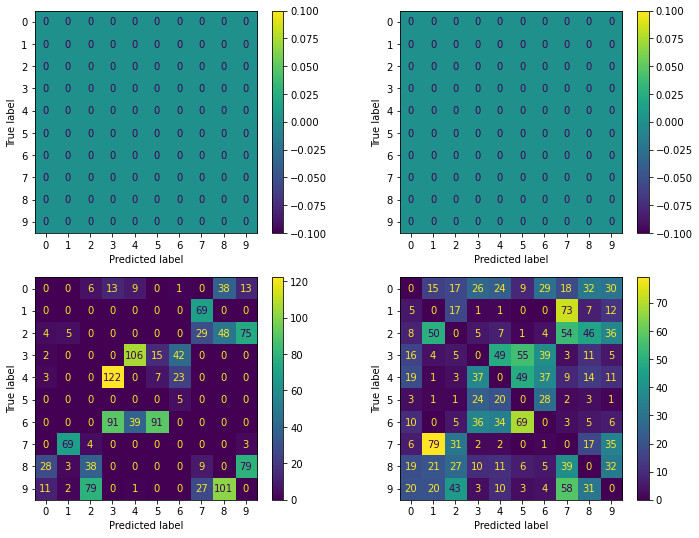

In [6]:
oof_preds, test_preds = score_model(ExtraTreesClassifier(**PARAMS))

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

submission['target'] = encoder.inverse_transform(test_preds)
submission.to_csv('../submissions/extratrees_baseline.csv', index=False)

# 1. Resampling

In [7]:
class Resampler(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.rng = np.random.default_rng()
        
    def fit(self, X, y, sample_weights):
        # Convert to integers
        temp = pd.DataFrame({
            col: ((X[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
        # Get GCDs
        gcd = temp[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, temp[col])
        
        # Raw histograms
        for col in features:
            temp[col] //= gcd
            temp[col] *= sample_weights
        
        # Get probabilities
        self.prob = dict()
        for label in np.unique(y):
            temp_vec = np.sum(temp[y == label], axis = 0) 
            self.prob[label] = temp_vec / np.sum(temp_vec)
        gc.collect()
        
    
    def transform(self, X, y, sample_weights):
        X = X[features].copy()
        rows, labels, gcds = list(), list(), list()
        for gcd, reads in [(10000, 100), (1000,1000)]:
            for label in np.unique(y):
                for _ in range(self.num_samples):
                    temp = Counter(
                        self.rng.choice(
                            features,
                            size = reads,
                            p = self.prob[label],
                        )
                    )
                    rows.append(temp)
                    labels.append(label)
                    gcds.append(gcd)
        new_samples = pd.DataFrame.from_records(rows, columns = features).fillna(0).astype(int) 
        gc.collect()
        for col in features:
            new_samples[col] *= gcds
            new_samples[col] /= 1000000
            new_samples[col] -= bias_of(col)
        new_samples['sample_weight'] = 1
        X['sample_weight'] = sample_weights
        new_samples['target'] = label
        X['target'] = y 
        new_samples = new_samples.sample(frac=1).reset_index(drop=True)   
        new_samples = pd.concat([X, new_samples], ignore_index = True).sample(frac=1).reset_index(drop=True)
        gc.collect()
        return new_samples[features], new_samples['target'], new_samples['sample_weight']



Fold 0: 0.93614 accuracy in 89.11s.
Fold 1: 0.93111 accuracy in 87.94s.
Fold 2: 0.93502 accuracy in 89.36s.
Fold 3: 0.92453 accuracy in 87.53s.
Fold 4: 0.93341 accuracy in 89.15s.
Fold 5: 0.93358 accuracy in 87.63s.
Fold 6: 0.92923 accuracy in 88.05s.
Fold 7: 0.92371 accuracy in 87.23s.
Fold 8: 0.93411 accuracy in 89.06s.
Fold 9: 0.93116 accuracy in 88.09s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.89037
Accuracy (100 Reads): 0.83444
Out-of-Fold Accuracy: 0.9312
Training Time: 883.17s


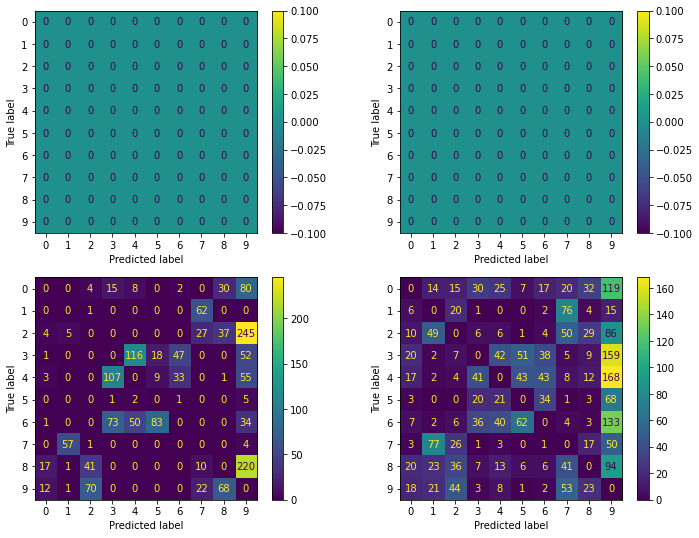

In [8]:
oof_preds, test_preds = score_model(
    ExtraTreesClassifier(**PARAMS),
    Resampler(750)
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])   

submission['target'] = encoder.inverse_transform(test_preds)
submission.to_csv('../submissions/resampling_submission.csv', index=False)

# 2. Data Augmentation

In [9]:
class Augmenter(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_samples, error_rate = 0.05):
        self.num_samples = num_samples
        self.rng = np.random.default_rng()
        self.rate = error_rate
        self.dist = [bias_of(x) for x in features]
        
    def fit(self, X, y, sample_weights):
        
        # Convert to integers
        temp = pd.DataFrame({
            col: ((X[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
        # Get GCDs
        gcd = temp[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, temp[col])
        
        # Raw histograms
        for col in features:
            temp[col] //= gcd
            temp[col] *= sample_weights
        
        # Save sample space
        temp['sample_weight'] = sample_weights
        temp['gcd'] = gcd
        temp['target'] = y
        self.samples = dict()
        self.prob = dict()
        for label in np.unique(y):
            self.samples[label] = temp[(temp.gcd > 100) & (temp.target == label)].reset_index(drop=True)
            self.prob[label] = temp[(temp.gcd > 100) & (temp.target == label)]['sample_weight'].to_numpy() / np.sum(temp[(temp.gcd > 100) & (temp.target == label)]['sample_weight'])
        
    
    def transform(self, X, y, sample_weights):
        X = X[features].copy()
        
        indices = list()
        labels = list()
        gcd = list()
        for label in sorted(np.unique(y)):
            # pick indices using sample weights
            temp = self.rng.choice(
                self.samples[label].index, 
                size = self.num_samples,
                p = self.prob[label]
            )
            indices.extend(temp)
            labels.extend([label,]*self.num_samples)
            gcd.extend([self.samples[label]['gcd'].loc[x] for x in temp])
        
        # Data for the new samples
        gcd = [self.samples[label]['gcd'].iloc[x] for x, label in zip(indices,labels)]
        rows = [Counter(self.samples[label][features].iloc[idx].to_dict()) for label, idx in zip(labels,indices)]
        
        # simulate errors
        for sample in rows:
            
            # Number of errors per sample
            num_errors = self.rng.binomial(
                n = sum(sample.values()), 
                p = self.rate
            )
            
            # Reads to replace with errors
            old_reads = self.rng.choice(
                list(sample.elements()), 
                size = num_errors,
                replace = False
            )
            
            # Erroneous reads
            new_reads = self.rng.choice(
                features, 
                size = num_errors,
                p = self.dist
            )
            
            sample.subtract(old_reads)
            sample.update(new_reads)
        
        new_samples = pd.DataFrame.from_records(rows, columns = features).fillna(0).astype(int)
        for col in features:
            new_samples[col] *= gcd
            new_samples[col] /= 1000000
            new_samples[col] -= bias_of(col)
        new_samples['target'] = labels
        new_samples['sample_weight'] = 1
        new_samples = new_samples.sample(frac=1).reset_index(drop=True)
        X = X[features].copy()
        X['sample_weight'] = sample_weights
        X['target'] = y
        new_samples = pd.concat([X, new_samples], ignore_index = True).sample(frac=1).reset_index(drop=True).fillna(0)
        return new_samples[features], new_samples['target'], new_samples['sample_weight']



Fold 0: 0.96246 accuracy in 120.31s.
Fold 1: 0.95527 accuracy in 118.56s.
Fold 2: 0.95779 accuracy in 118.39s.
Fold 3: 0.95987 accuracy in 118.05s.
Fold 4: 0.95811 accuracy in 118.11s.
Fold 5: 0.95848 accuracy in 118.64s.
Fold 6: 0.95526 accuracy in 118.41s.
Fold 7: 0.95535 accuracy in 117.85s.
Fold 8: 0.95602 accuracy in 118.3s.
Fold 9: 0.96008 accuracy in 117.98s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.92527
Accuracy (100 Reads): 0.90627
Out-of-Fold Accuracy: 0.95788
Training Time: 1184.6s


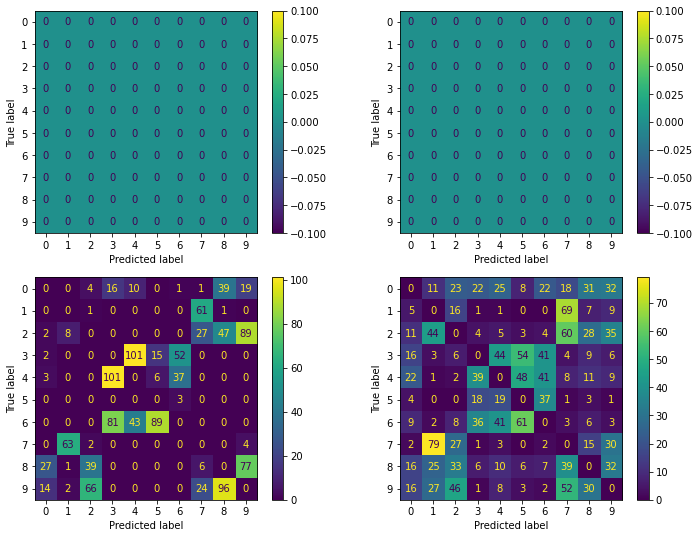

In [10]:
oof_preds, test_preds = score_model(
    ExtraTreesClassifier(**PARAMS),
    Augmenter(2500)
)

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])  

submission['target'] = encoder.inverse_transform(test_preds)
submission.to_csv('../submissions/augmentation_submission.csv', index=False)